# Lab 01
## Conrad Appel & Eric Hawkins

In [4]:
%matplotlib inline
import seaborn as sns
import pandas as p

The dataset we're using for this project is named "[Speed Dating Experiment](https://www.kaggle.com/annavictoria/speed-dating-experiment)" and was submitted to Kaggle by Anna Montoya. The data was collected by two Colombia professors, Ray Fisman and Sheena Iyengar, in order to discover what causes love at first sight.

The experiement was handled in a few distinct phases. First, participants answered general questions on themselves, such as their age, race, gender, income, career, interests, as well as what they look for in their dates. After this questionnaire, the participants each went on 10 rounds of 4-minute dates, and afterwards, rated each date's attributes, overall attractiveness, and whether or not they'd go on a second date. After these first 10 dates, the participants answered the same questions on what they find attractive in their dates and how they think they stood up. After 10 more dates, they'll answer the same questions one more time. Then, three weeks later, there was one last follow-up questionairre that asks how many dates each person met up with again, and who asked whom.

Through this data, we hope to discover the "key" to acquiring and impressing dates. We believe that this data set holds the key to what the most attractive attributes are in a person, at least for making first impressions. With the abundance of data available to us from this study, we believe we might be able to gather other interesting traits that have an effect on attractiveness. For example, we might be able to guess a person's confidence by comparing others' scores of them to their expected scores.

In [5]:
data = p.read_csv('./speeddating.csv', encoding='ISO-8859-1')
data['gender'] = data['gender'].apply(lambda v: 'Male' if v==1 else 'Female')

In [6]:
data['zipcode'].unique()[0:5]

array(['60,521', '35,223', '6,268', '77,096', '94,022'], dtype=object)

With the exception of the zipcode field, most of the fields look like they were imported correctly by pandas. There are some exceptions, such as the "id" column in which the datatype should have been an int instead of a float, but it shouldn't cause issues in the long run as none of the numbers are too big or too small (and if so, it will be easy to fix).

The zipcode field should be an "object" (really a string in this case) as it's not ordered data. However, the data was malformed in the input file, leading to values such as "60,521" and "6,268", which should be transformed to "60521" and "06268".

In [7]:
data['zipcode'] = data['zipcode'].apply(lambda v: str(v).replace(',', '').zfill(5))

Side-note: The fields ending with "_o" are scores that the participant's partner gave.

### Perceived Personality Traits

In the study, participants were asked to rate their partners on 6 individual personality traits, as well as overall attractiveness. These six traits are physical attractiveness, sincerity, intelligence, fun, ambition, and shared interests. For each of these traits, we compare a person's average likelihood for their partners to want to meet them again with the average score of the trait. This should make it easy for us to visualize which personality traits are most likely to be dealbreakers during the dating process.

Originally, we were using the individual's average overall attractiveness score. We saw that for this comparison, all the traits had a correlation of nearly 1. We decided that this makes a lot of sense - all 6 of these traits are highly desirable in a partner. However, this experiment only proved obvious knowledge, and didn't make any new insights, leading us to switch to the binary decision of the partner.

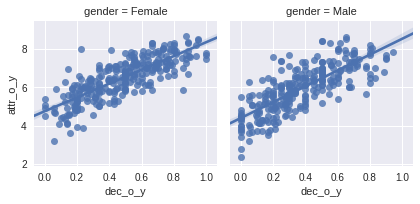

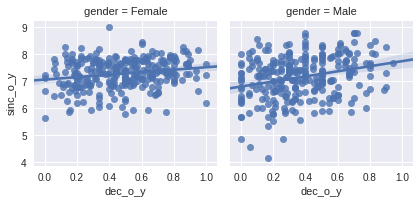

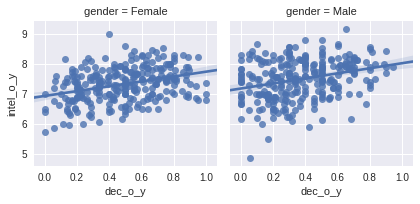

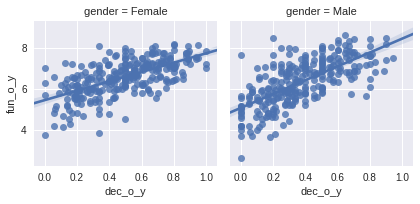

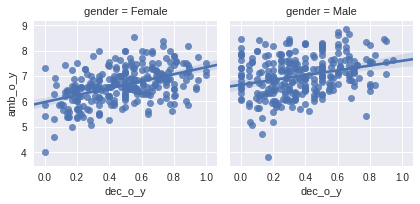

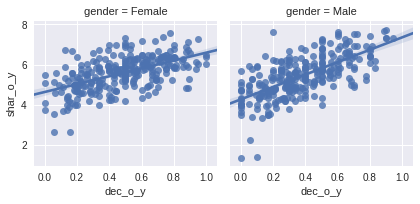

In [8]:
overall = data.drop_duplicates('iid')

for attribute in ['dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o']:
    cur = data.groupby('iid')[attribute].mean()
    overall = p.merge(overall, cur.reset_index(), on='iid')

for attribute, title in [('attr_o_y', 'Attraction'), ('sinc_o_y', 'Sincerity'), ('intel_o_y', 'Intelligence'), ('fun_o_y', 'Fun'), ('amb_o_y', 'Ambition'), ('shar_o_y', 'Shared Interests')]:
    tmp = sns.lmplot(x='dec_o_y', y=attribute, data=overall, size=3, col='gender')

In [9]:
overall_bygender = overall.groupby('gender')
for attribute, title in [('attr_o_y', 'Attraction'), ('sinc_o_y', 'Sincerity'), ('intel_o_y', 'Intelligence'), ('fun_o_y', 'Fun'), ('amb_o_y', 'Ambition'), ('shar_o_y', 'Shared Interests')]:
    print(title+' for men: '+str(overall_bygender.get_group('Male')['dec_o_y'].corr(overall_bygender.get_group('Male')[attribute])))
    print(title+' for women: '+str(overall_bygender.get_group('Female')['dec_o_y'].corr(overall_bygender.get_group('Female')[attribute])))

Attraction for men: 0.773068598611
Attraction for women: 0.79553478949
Sincerity for men: 0.270236532576
Sincerity for women: 0.197876423033
Intelligence for men: 0.289793509971
Intelligence for women: 0.339907620607
Fun for men: 0.684512487136
Fun for women: 0.630038836838
Ambition for men: 0.272848138557
Ambition for women: 0.461685713069
Shared Interests for men: 0.67068510782
Shared Interests for women: 0.558993962733


In the above graphs, a regression line is shown over a scatter plot of one point for each individual, comparing whether or not dates wanted to see them again to specific personality traits. Below the graphs, we've printed out the correlation coefficients for each trait in the eyes of both genders. We decided that a correlation coefficient closer to one means that a specific trait has more of an effect in a partner's eyes, in general.

Glancing at the data above, it's easy to see that attraction, fun, and shared interests are by far the most important traits to possess in order to have a successful dating experience, as these correlation coefficients are relatively closer to one. In the context of a four-minute first date, it would make sense that these traits are the most important. Looks initially capture the eye of the partner. Fun seems to exude from some people, leading them to make a good impression. Trying to find shared interests is one of the easier conversations to partake in when making small talk with a stranger.

In [10]:
import math

In [11]:
# Create set to contain pairs of participants where participant with iid
# has 'match' == 1 and participant with pid has 'dec_o' == 1 in the same row.
mut_matches = set()

In [12]:
# Dictionary to store field codes for iids and pids
field_codes = {}

In [13]:
# Dictionary for looking up the name associated with a field codes
field_key = {
	1: "Law",
	2: "Math",
	3: "Social Science, Psychology",
	4: "Medical Science, Pharmaceuticals, Bio-tech",
	5: "Engineering",
	6: "English, Creative Writing, Journalism",
	7: "History, Religion, Philosophy",
	8: "Business, Economics, Finance",
	9: "Education, Academia",
	10: "Biological Sciences, Chemistry, Physics",
	11: "Social Work",
	12: "Undergrad, Undecided",
	13: "Political Science, International Affairs",
	14: "Film",
	15: "Fine Arts, Arts Administration",
	16: "Languages",
	17: "Architecture",
	18: "Other"
}

In [14]:
for index, row in data.iterrows():
	if (row['match'] == 1 and row['dec_o'] == 1) and ('iid' in row and 'pid' in row and 'field_cd' in row and not math.isnan(row['field_cd'])):

		# Cast ids as ints
		row['iid'] = int(row['iid'])
		row['pid'] = int(row['pid'])

		# Sort tuples before adding them to the set. This is to ensure that a tuple
		# (a, b) and a tuple (b, a) are treated as equivalent.
		if row['iid'] < row['pid']:
			mut_matches.add((row['iid'], row['pid']))
		else:
			mut_matches.add((row['pid'], row['iid']))

		# Store field code if it is not already stored
		if row['iid'] not in field_codes:
			field_codes[row['iid']] = int(row['field_cd'])
		if row['pid'] not in field_codes:
			field_codes[row['pid']] = int(row['field_cd'])

In [15]:
xid, yid, xfield, yfield = [], [], [], []

# Populate lists to create a new dataframe
i = 1
for row in mut_matches:
    xid.append(row[0])
    yid.append(row[1])
    xfield.append(field_key[field_codes[row[0]]])
    yfield.append(field_key[field_codes[row[1]]])
    
    i += 1
    if i == 20: break

In [54]:
# Count total number of unique IDs
ids = set()
for id in xid:
    ids.add(id)
    
for id in yid:
    ids.add(id)
    
unique_ids = len(ids)

# Create lookup table for total IDs for each field
field_counts = {}
for id in ids:
    if field_key[field_codes[id]] not in field_counts:
        field_counts[field_key[field_codes[id]]] = 1
    else:
        field_counts[field_key[field_codes[id]]] += 1
    

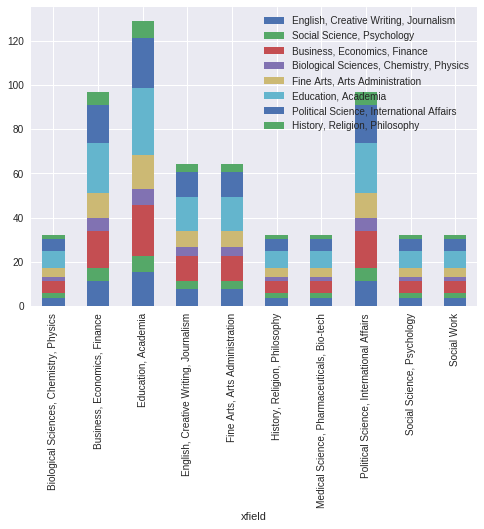

In [100]:
plot_data = p.DataFrame(data={'xid': xid, 'yid': yid, 'xfield': xfield, 'yfield': yfield})

total_matches = len(xid)



for field in yfield:
    plot_data[field] = plot_data['xfield'].value_counts()[field]
    
    # Partially normalize number of matches
    #plot_data[field] = (plot_data[field]*unique_ids) / total_matches

#for column, series in plot_data.iteritems():
    #if column not in ['xfield', 'xid', 'yfield', 'yid']:
       # for x in series.iteritems():
            #print(column, x)
            
#print(plot_data)

#for x in plot_data['xfield']:
    #for y in plot_data['yfield']:
        #print(plot_data[x])
        #print(plot_data[y])
        
# TODO: Figure out how to apply this normalization to each matching:
# (# of matches of this kind)*(total unique IDs)/((total matches)*(total IDs in each of the two fields))
    

plot_data.drop(['xid', 'yfield', 'yid'], axis=1).groupby('xfield').agg().plot(kind='bar', stacked=True)